# Evn

In [9]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [10]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [11]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [12]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [13]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [14]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [15]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [16]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units = 5)
output_11 = rnn_11(hidden)
print(output_11)

tf.Tensor([[ 0.0133051  -0.07108931  0.01356496  0.19825453 -0.03756267]], shape=(1, 5), dtype=float32)


In [19]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wy = weights[1]
b = weights[2]
print(Wx.shape)
print(Wy.shape)
print(b.shape)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [20]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units = 5, return_sequences = True)
output_12 = rnn_12(hidden)
print(output_12)

tf.Tensor(
[[[ 2.9929113e-02  4.1185715e-03 -7.3335785e-03 -2.7490623e-02
   -4.2592518e-02]
  [ 2.1723522e-02  3.4244298e-03 -8.8698808e-03  1.3401901e-02
   -2.1286123e-02]
  [ 4.8892803e-02 -1.5492372e-02  5.2009160e-03 -5.0389312e-02
   -6.7127943e-02]
  [ 5.3107738e-02  3.3684172e-02  4.7106575e-02  2.6926834e-02
   -1.6819069e-02]
  [ 6.6921949e-02 -6.2659383e-06  3.1169422e-02 -2.7292369e-02
    2.3001337e-02]
  [ 5.5012092e-02 -4.9766455e-02 -4.8280213e-02  2.3197087e-02
    1.8371815e-02]
  [ 1.5149739e-02 -9.3269765e-02  1.8400183e-02  7.5476407e-04
   -6.5119125e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [26]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units = 5, return_state = True)
output_13,  fw_h_13  = rnn_13(hidden)
print(output_13)

tf.Tensor([[-0.02579911 -0.12706426  0.12158298 -0.02453114  0.00580525]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [28]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units = 5, return_state = True, return_sequences = True)
output_14, fw_h_14  = rnn_14(hidden)
print(output_14)

tf.Tensor(
[[[-0.03193882 -0.0079272   0.0223878   0.0067434  -0.01425368]
  [-0.0033526   0.04714059 -0.0094431   0.0641433  -0.01378648]
  [-0.07008033  0.030615   -0.03443778  0.00931562 -0.02462979]
  [ 0.01590142 -0.05078726 -0.05236515  0.03970501 -0.03360384]
  [-0.10300475  0.03920037  0.00466558  0.01407208 -0.03848657]
  [ 0.02623866  0.01386815 -0.07196329  0.09742731 -0.04830532]
  [-0.08182613  0.03313228 -0.08073361 -0.02169145 -0.02739608]]], shape=(1, 7, 5), dtype=float32)


## init hidden state

In [29]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.00055441, -0.02368987,  0.03265708,  0.03472541, -0.01351652]],
      dtype=float32)>

In [30]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.03429853,  0.06319375, -0.01609682, -0.08867372,
         -0.10590921],
        [ 0.00280256,  0.11997723, -0.02171298, -0.01941258,
         -0.03240532],
        [ 0.05317126,  0.05361114, -0.01054874, -0.1440454 ,
         -0.03108713],
        [ 0.10560691,  0.07743868, -0.02812873, -0.04173192,
         -0.0195738 ],
        [ 0.13991353,  0.02032074,  0.0261084 , -0.10611843,
         -0.03073501],
        [ 0.15830655,  0.00517944, -0.02848466,  0.01243293,
         -0.00157213],
        [ 0.11171678, -0.09203577,  0.06051857, -0.03330509,
         -0.01792135]]], dtype=float32)>

In [31]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state=[fw_h_13])  # (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.1109219 , -0.23854558,  0.18744917, -0.0393621 ,  0.01659918]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.1109219 , -0.23854558,  0.18744917, -0.0393621 ,  0.01659918]],
       dtype=float32)>]

In [32]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.05494859, -0.068688  , -0.04997031,  0.07857765,
          -0.04372155],
         [-0.07321598,  0.11836709, -0.06282889,  0.10506113,
          -0.04343329],
         [-0.05837944,  0.0007092 , -0.14658809,  0.03201451,
          -0.05610854],
         [-0.09303141, -0.04129592, -0.10190418,  0.06240162,
          -0.0434189 ],
         [-0.09092571,  0.033149  , -0.07356862,  0.10195009,
          -0.06856728],
         [-0.04214918,  0.06580289, -0.15549892,  0.08473659,
          -0.06266189],
         [-0.10188934, -0.03036649, -0.16404143,  0.03290911,
          -0.03880826]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.10188934, -0.03036649, -0.16404143,  0.03290911, -0.03880826]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [33]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor(
[[ 7.6129837e-03 -1.5287815e-02  7.3035844e-03  4.7374528e-05
   1.1121367e-02]], shape=(1, 5), dtype=float32)


In [34]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wy = weights[1]
b = weights[2]
print(Wx.shape)
print(Wy.shape)
print(b.shape)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [35]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 0.00040525 -0.00275002  0.00038114 -0.00120663  0.00231446]
  [-0.00520107 -0.00223845 -0.00043894 -0.0053069  -0.00388033]
  [-0.00688379 -0.00716671 -0.00024295 -0.00974881 -0.00305707]
  [-0.00176606 -0.0059406   0.00495924 -0.00458891 -0.00075247]
  [-0.00092784 -0.00677031  0.00413757 -0.00491618  0.00158901]
  [-0.00619131 -0.00487417  0.00241962 -0.00824052 -0.00451456]
  [-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [36]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor([[ 0.00699196  0.00437341  0.0025941  -0.0012665   0.00110581]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00699196  0.00437341  0.0025941  -0.0012665   0.00110581]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.01388794  0.00880195  0.00519288 -0.00253302  0.00220683]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [37]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[-0.00031232  0.00035    -0.00602605  0.00325187  0.00500193]
  [ 0.00191611 -0.00246147 -0.00247776 -0.00149736  0.00335464]
  [ 0.00395028 -0.00199805 -0.01084031  0.00352603  0.01166661]
  [ 0.00885272  0.00383132 -0.00738862  0.00178646  0.00752748]
  [ 0.00712753  0.00394021 -0.01201764  0.00329205  0.01241342]
  [ 0.00850007  0.00089784 -0.00745089 -0.00247206  0.01025239]
  [ 0.01270817  0.00426247 -0.00694759 -0.00339906  0.00714147]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01270817  0.00426247 -0.00694759 -0.00339906  0.00714147]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.02524673  0.00855356 -0.0138775  -0.00675537  0.01418354]], shape=(1, 5), dtype=float32)


## init hidden state

In [38]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 8.6140092e-03, -1.4793157e-02,  8.2151778e-03, -7.0997681e-05,
         1.1773557e-02]], dtype=float32)>

In [39]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.01051062,  0.00088103, -0.00509646, -0.00280319,
          0.00582686],
        [ 0.00278326,  0.00079286, -0.00476723, -0.00585448,
         -0.00254968],
        [-0.00068178, -0.00465215, -0.00371528, -0.0097092 ,
         -0.00291549],
        [ 0.00312619, -0.00384951,  0.00211185, -0.00424073,
         -0.00124406],
        [ 0.00290549, -0.00507619,  0.0018576 , -0.00442333,
          0.00081194],
        [-0.00321988, -0.00350767,  0.00059108, -0.00770123,
         -0.00536728],
        [-0.00131248, -0.00359946,  0.00540784, -0.00490146,
         -0.00337581]]], dtype=float32)>

In [45]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00770496,  0.00434116,  0.00194463, -0.00196943,  0.00152848]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00770496,  0.00434116,  0.00194463, -0.00196943,  0.00152848]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01530678,  0.00873474,  0.00389256, -0.0039401 ,  0.00305044]],
       dtype=float32)>]

In [41]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14])

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.01049861,  0.00422002, -0.0119902 , -0.00063109,
           0.01185338],
         [ 0.01149647,  0.00107674, -0.00764428, -0.00555346,
           0.00965519],
         [ 0.01228009,  0.00118572, -0.01549886, -0.00051208,
           0.01758492],
         [ 0.01631672,  0.00664485, -0.01156615, -0.0020623 ,
           0.01285674],
         [ 0.01368803,  0.0064662 , -0.01578252, -0.00031173,
           0.01728946],
         [ 0.0144625 ,  0.00318704, -0.01082227, -0.00584687,
           0.01459741],
         [ 0.01805097,  0.00629043, -0.01002929, -0.00652198,
           0.0110887 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01805097,  0.00629043, -0.01002929, -0.00652198,  0.0110887 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03584805,  0.0126378 , -0.02004248, -0.01297265,  0.02199908]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [ ]:
# GRU

In [ ]:
# GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [ ]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [ ]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [ ]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [42]:
# bi rnn
# rnn_11 = tf.keras.layers.SimpleRNN(units=5)
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.10336562  0.08199173 -0.09182289 -0.00289055  0.17580172  0.05653751
  -0.03108167 -0.00434958  0.02248471 -0.02679492]], shape=(1, 10), dtype=float32)


In [43]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [44]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.00393843  0.01643303 -0.00768831  0.02353974  0.00091918
   -0.10349478 -0.0285648  -0.15433243  0.04896942  0.06491221]
  [ 0.02809035 -0.01311906  0.02280344  0.03680439  0.03804762
    0.02943007  0.02542512  0.11362046 -0.12041495 -0.02427353]
  [-0.01071677  0.0317449   0.00194325  0.04848466  0.08904895
   -0.01399157  0.03664462 -0.08559737  0.02306108  0.03876172]
  [-0.07789654 -0.0555984   0.07450786  0.00648022  0.0571234
    0.03886566 -0.04035225  0.02026285 -0.0976572  -0.04407607]
  [-0.11608811  0.05774676 -0.03319248 -0.00088602 -0.02194126
   -0.03242294 -0.00163622 -0.08538932 -0.02830599  0.10822444]
  [-0.00364904 -0.03016905  0.04510754  0.0952244  -0.07422729
    0.03443364 -0.01166542  0.06866754 -0.04004517  0.06915002]
  [ 0.00189245 -0.08352485 -0.07952984 -0.02134595  0.01254619
   -0.01275779 -0.02096113  0.03646116  0.01574588  0.01673784]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [47]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[-0.0069922   0.11693995  0.02447139  0.02125133  0.06086859  0.03373569
   0.14357285  0.02265848 -0.01834988  0.01760596]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.0069922   0.11693995  0.02447139  0.02125133  0.06086859]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.03373569  0.14357285  0.02265848 -0.01834988  0.01760596]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [48]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.03257512  0.00966452  0.01214427  0.00878473  0.01693241
    0.19237266 -0.0812621   0.04585575  0.21233375 -0.06199192]
  [ 0.0011852   0.01813869 -0.00712182  0.02801438  0.06002924
    0.19568789 -0.15625991 -0.07476489  0.11430406  0.00654601]
  [ 0.00401715  0.02285646  0.02328973  0.03333241  0.11561715
    0.16033162 -0.07842326  0.01079783  0.12863927 -0.04709422]
  [ 0.05736993 -0.03698183 -0.00975392  0.01308094  0.09772428
    0.08594774 -0.10521452 -0.02100909  0.03410326  0.00119129]
  [ 0.04496021 -0.0503803  -0.01180103  0.06208536  0.05461008
    0.06124195 -0.05519117  0.01020906  0.07788463 -0.05437578]
  [ 0.08442385 -0.00549539  0.01153838  0.10785294  0.0481703
    0.04696892 -0.06332669 -0.04169358  0.04113318 -0.03293794]
  [ 0.10142464  0.04384788  0.03959855  0.09941956  0.05877534
    0.02087322 -0.0319039  -0.02556017  0.00514512 -0.00664387]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[0.10142464 0.04384788 0.03959855 0.09941956 0.0587753

## init hidden state

In [49]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.19649178,  0.10103466, -0.15863104, -0.01982271,  0.1302655 ,
         0.07452574, -0.02354365,  0.08072764,  0.01025268, -0.1440842 ]],
      dtype=float32)>

In [50]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00987273, -0.06312342,  0.02498274, -0.04986942,
          0.11917541, -0.09725527, -0.23567978, -0.14445539,
          0.18366566, -0.04445881],
        [-0.05651297,  0.11924736,  0.04853557,  0.03540837,
          0.07604313, -0.19472326,  0.01366047,  0.14846821,
         -0.16881412, -0.1715113 ],
        [-0.06618687, -0.03145315,  0.11450179,  0.03945192,
          0.00659977, -0.03471306,  0.2970389 , -0.14226902,
         -0.02292334, -0.02327482],
        [-0.10822732, -0.02784914, -0.0295678 , -0.07354299,
         -0.03011701,  0.28855893, -0.01663314, -0.11514193,
         -0.12776706, -0.05934961],
        [-0.01273585,  0.0742615 , -0.02317247,  0.09080166,
         -0.10473048, -0.02167492, -0.25309822, -0.17666018,
         -0.13237481,  0.17390026],
        [ 0.07846123, -0.12574023, -0.01398235,  0.03845133,
         -0.01488926, -0.16291319, -0.01675338,  0.18327321,
         -0.16297589,  0.22117849],


In [51]:
# bi_rnn_13 with fw_h_13, bw_h_13
bi_rnn_13(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, n_seq, units * 2)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 7.1167829e-03, -8.3331484e-05,  2.9215159e-02, -2.6119854e-02,
          2.1190394e-02, -6.0106777e-02,  1.7747335e-01, -7.1576200e-02,
         -5.1974591e-02,  5.5431094e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 7.1167829e-03, -8.3331484e-05,  2.9215159e-02, -2.6119854e-02,
          2.1190394e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.06010678,  0.17747335, -0.0715762 , -0.05197459,  0.05543109]],
       dtype=float32)>]

In [52]:
# bi_rnn_14 with fw_h_14, bw_h_14
bi_rnn_14(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 0.07005055,  0.06352428,  0.04334629,  0.07131249,
           0.11001899,  0.31769818, -0.1452783 ,  0.04461537,
           0.30978465,  0.12155465],
         [ 0.11488549,  0.04636652, -0.01173611,  0.06917052,
           0.16540964,  0.32496032, -0.14256643,  0.00514445,
           0.30999002,  0.08115441],
         [ 0.13950185,  0.01806827,  0.00411688,  0.07282356,
           0.19108976,  0.33430746, -0.15604594, -0.02335311,
           0.24663547,  0.10271578],
         [ 0.19916748, -0.03521172, -0.02904013,  0.07432853,
           0.12890886,  0.27345288, -0.10780258,  0.05053091,
           0.22929624,  0.03467289],
         [ 0.18245634, -0.01097679, -0.00600376,  0.12502185,
           0.0651835 ,  0.27729598, -0.17138517, -0.01348935,
           0.18334319,  0.0548305 ],
         [ 0.20508023,  0.07374736,  0.01765153,  0.15341312,
           0.077177  ,  0.24661008, -0.11885047,  0.04074113,
           0.23612

# Bidirectional LSTM

## return sequence=False, return_state=False

In [53]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5))
output_11 = bi_lstm_11(hidden)  # (bs, seq, units * 2)
print(output_11)

tf.Tensor(
[[ 0.00214849  0.00750927 -0.00475502 -0.01640727  0.00873092  0.01061551
   0.02445016 -0.01758546 -0.01038147 -0.00147526]], shape=(1, 10), dtype=float32)


In [54]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)


(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [55]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[-0.00343211  0.00427207 -0.00149899 -0.00175388  0.00288509
   -0.01022396  0.00184914  0.00054924  0.01690395  0.00960285]
  [-0.00409099  0.00202942  0.00721819 -0.00574669 -0.00622326
   -0.01476382  0.00173948  0.00582865  0.02104549  0.00563509]
  [-0.01035338  0.00417277  0.01047851 -0.01176224 -0.0055351
   -0.01037649  0.00542541  0.00170364  0.01396343  0.0097188 ]
  [-0.00682242 -0.00045549  0.00926379 -0.01262906 -0.00415865
   -0.00166856  0.00173698  0.00273817  0.00935064  0.00197046]
  [-0.00990969  0.00188193  0.00703507 -0.01174963 -0.0005921
   -0.00691527  0.00301772  0.00103501  0.00954941  0.00355421]
  [-0.01033755 -0.00128346  0.01477415 -0.01393084 -0.00927528
   -0.00937781  0.00124433  0.00609079  0.01252479 -0.00211555]
  [-0.01047844 -0.00272136  0.01447616 -0.015981   -0.00944974
   -0.00154288  0.00237533  0.00123851  0.00431662 -0.00023999]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [56]:
# (return_state=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[-0.0091411  -0.00195886 -0.01065393  0.00111449  0.00126692  0.00095727
  -0.00672461  0.00755316 -0.00082623 -0.00279788]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.0091411  -0.00195886 -0.01065393  0.00111449  0.00126692]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01845419 -0.00390338 -0.02142009  0.00223889  0.00253656]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00095727 -0.00672461  0.00755316 -0.00082623 -0.00279788]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00190882 -0.01344635  0.01523693 -0.0016498  -0.00565249]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [57]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[-0.00265786 -0.0043344   0.00013482  0.00021896  0.00235112
    0.01547839  0.00376636 -0.00398766 -0.00370576 -0.00819959]
  [-0.00449128 -0.00437867 -0.00593121  0.00924517  0.00283331
    0.01751981  0.0049557  -0.00431832 -0.00138006 -0.00634429]
  [-0.00937262 -0.01305849 -0.00901041  0.01327662  0.00807199
    0.01378284  0.00387323 -0.00220566  0.00160091 -0.00953445]
  [-0.00559793 -0.01018761 -0.00705128  0.00901377  0.00187473
    0.00511518  0.00353836 -0.00231105  0.00052435 -0.00378776]
  [-0.00693194 -0.01262938 -0.00397775  0.00756546  0.003328
    0.00971271  0.00036867 -0.00292887 -0.00174154 -0.00260874]
  [-0.00763143 -0.01133148 -0.0081919   0.01510806  0.00309236
    0.0093383   0.00124105 -0.00361729 -0.00029563  0.00060674]
  [-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.00082833
    0.00253888  0.00025405 -0.00196356  0.00069703 -0.00069011]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.000

## init hidden state

In [58]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.00015727,  0.00645132, -0.00491892, -0.01579176,  0.01023728,
         0.0111484 ,  0.02326883, -0.01610018, -0.00986538, -0.00124236]],
      dtype=float32)>

In [59]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00878573, -0.00138058, -0.00968741,  0.00640582,
          0.00185933, -0.0087426 ,  0.00403183,  0.00167814,
          0.01551284,  0.00888616],
        [-0.0080578 , -0.00069413, -0.00048683, -0.00101975,
         -0.00723064, -0.01281356,  0.00418963,  0.00720075,
          0.01938561,  0.00453016],
        [-0.01302137,  0.0030489 ,  0.00382255, -0.00920187,
         -0.00642651, -0.00775529,  0.00828512,  0.00324923,
          0.01202187,  0.00806246],
        [-0.0085477 , -0.00070268,  0.00368323, -0.01126228,
         -0.00488006,  0.00182763,  0.00492204,  0.00440744,
          0.00702173, -0.00042675],
        [-0.0108273 ,  0.00209046,  0.002517  , -0.0111129 ,
         -0.00116849, -0.00197708,  0.0065663 ,  0.00252955,
          0.00687623,  0.00017145],
        [-0.01069329, -0.00088743,  0.01118687, -0.01366006,
         -0.00971235, -0.00227178,  0.00494221,  0.00695366,
          0.00949318, -0.00672844],


In [60]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_13(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.01060613, -0.00044312, -0.01230804,  0.00138573,  0.00019193,
          0.00061173, -0.00648881,  0.0088145 , -0.00125043, -0.00292507]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01060613, -0.00044312, -0.01230804,  0.00138573,  0.00019193]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.02140639, -0.00088309, -0.02474167,  0.00278313,  0.00038402]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00061173, -0.00648881,  0.0088145 , -0.00125043, -0.00292507]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00121978, -0.01297695,  0.0177801 , -0.0024977 , -0.00591112]],
       dtype=float32)>]

In [61]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_14(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-0.00774355, -0.01295746, -0.00405065,  0.01043981,
           0.00124875,  0.01593335,  0.0055482 , -0.0060663 ,
          -0.00531265, -0.01116456],
         [-0.00820688, -0.01174138, -0.00796207,  0.01689337,
           0.00146916,  0.01856684,  0.0071922 , -0.00670562,
          -0.0034877 , -0.00981428],
         [-0.01227498, -0.01907885, -0.00973774,  0.01873495,
           0.00649545,  0.01572705,  0.00661363, -0.00490237,
          -0.00109548, -0.01360102],
         [-0.00785209, -0.01521566, -0.00708225,  0.01285051,
           0.00020118,  0.00833403,  0.00686727, -0.00530441,
          -0.00282576, -0.00831763],
         [-0.00873067, -0.0167442 , -0.00366233,  0.0101155 ,
           0.00167253,  0.01477287,  0.00422002, -0.00616001,
          -0.00572966, -0.00786389],
         [-0.00901457, -0.01475132, -0.00773761,  0.01670974,
           0.001539  ,  0.0169783 ,  0.00554933, -0.0071059 ,
          -0.00470

# Bidirectional GRU

## return sequence=False, return_state=False

In [ ]:
# bi GRU

In [ ]:
# bi GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
# bi_gru_11 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_12 with fw_h_14, bw_h_14

In [ ]:
# bi_gru_13 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_14 with fw_h_14, bw_h_14

# RNN 모델

In [64]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    rnn_1 = tf.keras.layers.SimpleRNN(units = 128, return_sequences = True)
    hidden = rnn_1(hidden)
    rnn_2 = tf.keras.layers.SimpleRNN(units = 256, return_sequences = True)
    hidden = rnn_2(hidden)
    ########################################
    #rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 128, return_sequences = True))
    #hidden = rnn_1(hidden)
    #rnn_2 = tf.keras.layers.SimpleRNN(units = 128, return_sequences = True)
    #hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

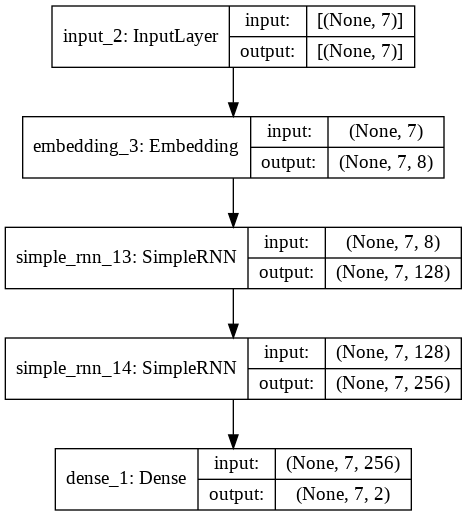

In [65]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [66]:
model.predict(train_inputs)

array([[[0.49835306, 0.50164694],
        [0.5038759 , 0.49612403],
        [0.49508885, 0.50491107],
        [0.4869011 , 0.51309884],
        [0.5060971 , 0.4939029 ],
        [0.4978192 , 0.50218076],
        [0.4664903 , 0.53350973]]], dtype=float32)